 # Feature Store Tour - Python API
 
This notebook contains a tour/reference for the feature store Python API on hopsworks. The notebook is meant to be run from feature store demo projects on Hopsworks. We will go over best practices for using the API as well as common pitfalls.
 
The notebook is designed to be used in combination with the Feature Store Tour on Hopsworks, it assumes that you have run the following feature engineering job: [job](https://github.com/logicalclocks/hops-examples/tree/master/featurestore_tour) (**the job is added automatically when you start the feature store tour in Hopsworks. You can run the job by going to the 'Jobs' tab to the left in the Hopsworks project home page**). 

Which will produce the following model of feature groups in your project's feature store:

![Feature Store Model](./images/model.png "Feature Store Model")

In this notebook we will run queries over this feature store model. We will also create new feature groups and training datasets.

We will go from (1) features to (2) training datasets to (3) A trained model

## Feature Store 101

The simplest way to think about the feature store is as a central place to store curated /features/ within an organization. A feature is a measurable property of some phenomenon. It could be for example an image-pixel, a word from a piece of text, the age of a person, a coordinate emitted from a sensor, or an aggregate value like the average number of purchases within the last hour.

A feature store is a data management layer for machine learning that can optimize the machine learning workflow and provide an interface between data engineering and data science.

![Feature Store Overview](./images/overview.png "Feature Store Overview")

A feature store is not a pure storage service, it goes hand-in-hand with feature computation. Feature engineering is the process of transforming raw data into a format that is compatible and understandable for predictive models.

There are two interfaces to the feature store:

- Writing to the feature store, at the end of the feature engineering pipeline the features are written to the feature store, e.g:
```python
raw_data = spark.read.format("csv").load(filename)
polynomial_features = raw_data.map(lambda x: x^2)
from hops import featurestore
featurestore.insert_into_featuregroup(polynomial_features, "polynomial_features")
```
- Reading from the feature store, to train a model on a set of features, the features can be read from the feature store, e.g:
```python
from hops import featurestore
features_df = featurestore.get_features(["team_budget", "average_attendance", "average_player_age"])
```

As a data engineer/data scientist, you can think of the feature store as a middle-layer. Once you have computed a set of features, instead of writing them locally to a csv file, insert them in the feature store so that the features can get documented/versioned, backfilled, **and so that your colleagues can re-use your features!** 

In this notebook we will take a look at interacting with the Feature Store through the Python SDK,there is also a Scala SDK available if you prefer that.

## Imports

The hops library is automatically installed in all Hopsworks-projects. This library has a module called `featurestore` that provides an API for the feature store. You can find API documentation [here](http://hops-py.logicalclocks.com/).

In [1]:
from hops import featurestore

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log
2,application_1587142366063_0004,pyspark,idle,Link,Link


SparkSession available as 'spark'.


In [2]:
%%local
%matplotlib inline
from hops import featurestore

## Get The Name of The Project's Feature Store

Each project with the feature store service enabled automatically gets its own feature store created. This feature store is only accessible within the project unless you decide to share it with other projects. The name of the feature store is `<project_name>_featurestore`, and you can get the name with the API method `project_featurestore()`. 

In [3]:
featurestore.project_featurestore()

'demo_featurestore_admin000_featurestore'

## Get a List of All Feature Stores Accessible in the Current Project 

Feature Stores can be shared across projects in a multi-tenant manner, just like any Hopsworks-dataset can. You can read more about sharing datasets at [hops.io](hops.io), but in essence to share a dataset you just have to right click on it in your project. The feature groups in the feature store are located in a dataset called `<project_name>_featurestore.db` in your project.

![Share Feature Store](./images/share_featurestore.png "Share Feature Store")

In [4]:
featurestore.get_project_featurestores()

['demo_featurestore_admin000_featurestore']

## Querying The Feature Store

The feature store can be queried programmatically and with raw SQL. When you query the feature store programmatically, the library will infer how to fetch the different features using a **query planner**. 

![Feature Store Query Planner](./images/query_optimizer.png "Feature Store Query Planner")

When interacting with the feature store it is sufficient to be familiar with three concepts:

- The **feature**, this refer to an individual versioned and documented feature in the feature store, e.g the age of a person.
- The **feature group**, this refer to a documented and versioned group of features stored as a Hive table that is linked to a specific Spark/Numpy/Pandas job that takes in raw data and outputs the computed features.
- The **training dataset**, this refer to a versioned and managed dataset of features, stored in HopsFS as tfrecords, .csv, .tsv, or parquet.

A feature group contains a group of features and a training dataset contains a set of features, potentially from many different feature groups.

![Feature Store Concepts](./images/concepts.png "Feature Store Contents")

When you query the feature store you will always get back the results in a spark dataframe. This is for scalability reasons. If the dataset is small and you want to work with it in memory you can convert it into a pandas dataframe or a numpy matrix using one line of code as we will demonstrate later on in this notebook.

### Fetch an Individual Feature

When retrieving a single feature from the featurestore, the hops-util-py library will infer in which feature group the feature belongs to by querying the metastore, but you can also explicitly specify which featuregroup and version to query. 

If there are multiple features of the same name in the featurestore, it is required to specify enough information to uniquely identify the feature (e.g specify feature group and version). If no featurestore is provided it will default to the project's featurestore.

To read an individual feature, use the method `get_feature(feature_name)`

Without specifying the feature store, feature group and version, the library will infer it:

In [5]:
featurestore.get_feature("team_budget").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 1 feature from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT team_budget FROM teams_features_1 against offline feature store
+-----------+
|team_budget|
+-----------+
|  12957.076|
|  2403.3704|
|  3390.3755|
|  13547.429|
|   9678.333|
+-----------+
only showing top 5 rows

You can also explicitly specify the feature store, feature group, the version, and the return format:

In [6]:
featurestore.get_feature(
    "team_budget", 
    featurestore=featurestore.project_featurestore(), 
    featuregroup="teams_features", 
    featuregroup_version = 1,
    dataframe_type = "spark"
).show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 1 feature from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT team_budget FROM teams_features_1 against offline feature store
+-----------+
|team_budget|
+-----------+
|  12957.076|
|  2403.3704|
|  3390.3755|
|  13547.429|
|   9678.333|
+-----------+
only showing top 5 rows

### Fetch an Entire Feature Group

You can get an entire featuregroup from the API. If no feature store is provided the API will default to the project's feature store, if no version is provided it will default to version 1 of the feature group. The default return format is as a spark dataframe.

In [7]:
featurestore.get_featuregroup("teams_features").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_1 against offline feature store
+-----------+-------+-------------+
|team_budget|team_id|team_position|
+-----------+-------+-------------+
|  12957.076|      1|            1|
|  2403.3704|      2|            2|
|  3390.3755|      3|            3|
|  13547.429|      4|            4|
|   9678.333|      5|            5|
+-----------+-------+-------------+
only showing top 5 rows

The default parameters can be overriden:

In [8]:
featurestore.get_featuregroup(
    "teams_features", 
    featurestore=featurestore.project_featurestore(), 
    featuregroup_version = 1,
    dataframe_type = "spark"
).show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_1 against offline feature store
+-----------+-------+-------------+
|team_budget|team_id|team_position|
+-----------+-------+-------------+
|  12957.076|      1|            1|
|  2403.3704|      2|            2|
|  3390.3755|      3|            3|
|  13547.429|      4|            4|
|   9678.333|      5|            5|
+-----------+-------+-------------+
only showing top 5 rows

### Fetch A Set of Features

When retrieving a list of features from the featurestore, the hops-util-py library will infer which featuregroup the features belongs to by querying the metastore. If the features reside in different featuregroups, the library will also try to infer how to join the features together based on common columns. If the JOIN query cannot be inferred due to existence of multiple features with the same name or non-obvious JOIN query, the user need to supply enough information to the API call to be able to query the featurestore. If the user already knows the JOIN query it can also run featurestore.sql(joinQuery) directly (an example of this is shown further down in this notebook). If no featurestore is provided the API will default to the project's featurestore.

Example of querying the feature store for a list of features without specifying the feature groups and feature store:

In [9]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age"]
).show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT average_player_age, team_budget, average_attendance FROM players_features_1 JOIN teams_features_1 JOIN attendances_features_1 ON players_features_1.`team_id`=teams_features_1.`team_id` AND players_features_1.`team_id`=attendances_features_1.`team_id` against offline feature store
+------------------+-----------+------------------+
|average_player_age|team_budget|average_attendance|
+------------------+-----------+------------------+
|             24.63|  12514.562|         3587.5015|
|             25.71|  1587.0897|         2532.1638|
|             25.63|  3839.0754|         3397.8066|
|             25.65|  16758.066|          3271.934|
|              25.5|  3966.3591|         4074.8047|
+------------------+-----------+------------------+
only showing 

We can also explicitly specify the feature groups where the features reside. Either the feature groups and versions can be specified by prepending feature names with `<feature group name>_<feature group version.`, or by providing a dict with entries of `<feature group name> -> <feature group version>`:

In [10]:
featurestore.get_features(
    ["teams_features_1.team_budget", 
     "attendances_features_1.average_attendance", 
     "players_features_1.average_player_age"]
).show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT attendances_features_1.average_attendance, teams_features_1.team_budget, players_features_1.average_player_age FROM attendances_features_1 JOIN teams_features_1 JOIN players_features_1 ON attendances_features_1.`team_id`=teams_features_1.`team_id` AND attendances_features_1.`team_id`=players_features_1.`team_id` against offline feature store
+------------------+-----------+------------------+
|average_attendance|team_budget|average_player_age|
+------------------+-----------+------------------+
|         3587.5015|  12514.562|             24.63|
|         2532.1638|  1587.0897|             25.71|
|         3397.8066|  3839.0754|             25.63|
|          3271.934|  16758.066|             25.65|
|         4074.8047|  3966.3591|              25.5|
+-

In [11]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age"],
    featurestore=featurestore.project_featurestore(),
    featuregroups_version_dict={
        "teams_features": 1, 
        "attendances_features": 1,
        "players_features": 1
    }
).show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT average_player_age, team_budget, average_attendance FROM attendances_features_1 JOIN players_features_1 JOIN teams_features_1 ON attendances_features_1.`team_id`=players_features_1.`team_id` AND attendances_features_1.`team_id`=teams_features_1.`team_id` against offline feature store
+------------------+-----------+------------------+
|average_player_age|team_budget|average_attendance|
+------------------+-----------+------------------+
|             24.63|  12514.562|         3587.5015|
|             25.71|  1587.0897|         2532.1638|
|             25.63|  3839.0754|         3397.8066|
|             25.65|  16758.066|          3271.934|
|              25.5|  3966.3591|         4074.8047|
+------------------+-----------+------------------+
only show

If you have a lot of name collisions and it is not obvious how to infer the JOIN query to get the features from the feature store. You can explicitly specify the argument `join_key` to the API (or you can provide the entire SQL query using the API method `.sql` as we will demonstrate later on in the notebook)

In [12]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age"],
    featurestore=featurestore.project_featurestore(),
    featuregroups_version_dict={
        "teams_features": 1, 
        "attendances_features": 1,
        "players_features": 1
    },
    join_key = "team_id",
    dataframe_type = "spark"
).show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT average_player_age, team_budget, average_attendance FROM teams_features_1 JOIN attendances_features_1 JOIN players_features_1 ON teams_features_1.`team_id`=attendances_features_1.`team_id` AND teams_features_1.`team_id`=players_features_1.`team_id` against offline feature store
+------------------+-----------+------------------+
|average_player_age|team_budget|average_attendance|
+------------------+-----------+------------------+
|             24.63|  12514.562|         3587.5015|
|             25.71|  1587.0897|         2532.1638|
|             25.63|  3839.0754|         3397.8066|
|             25.65|  16758.066|          3271.934|
|              25.5|  3966.3591|         4074.8047|
+------------------+-----------+------------------+
only showing to

#### Advanced Eamples of Fetching Sets of Features and Common Pitfalls

Getting 12 features from 4 different feature groups:

In [13]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age",
    "team_position", "sum_attendance", 
     "average_player_rating", "average_player_worth", "sum_player_age",
     "sum_player_rating", "sum_player_worth", "sum_position", 
     "average_position"
    ]
).show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 12 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT team_budget, average_position, sum_player_rating, average_attendance, average_player_worth, sum_player_worth, sum_position, sum_attendance, average_player_rating, team_position, sum_player_age, average_player_age FROM teams_features_1 JOIN season_scores_features_1 JOIN players_features_1 JOIN attendances_features_1 ON teams_features_1.`team_id`=season_scores_features_1.`team_id` AND teams_features_1.`team_id`=players_features_1.`team_id` AND teams_features_1.`team_id`=attendances_features_1.`team_id` against offline feature store
+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|team_budget|average_

### Free Text SQL Query from the Feature Store

For complex queries that cannot be inferred by the helper functions, enter the sql directly to the method `featurestore.sql()` it will default to the project specific feature store but you can also specify it explicitly. If you are proficient in SQL, this is the most efficient and preferred way to query the feature store.

Without specifying the feature store the query will by default be run against the project's feature store:

In [14]:
featurestore.sql("SELECT * FROM teams_features_1 WHERE team_position < 5").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Running sql: SELECT * FROM teams_features_1 WHERE team_position < 5 against offline feature store
+-----------+-------+-------------+
|team_budget|team_id|team_position|
+-----------+-------+-------------+
|  12957.076|      1|            1|
|  2403.3704|      2|            2|
|  3390.3755|      3|            3|
|  13547.429|      4|            4|
+-----------+-------+-------------+

You can also specify the featurestore to query and the return format explicitly:

In [15]:
featurestore.sql("SELECT * FROM teams_features_1 WHERE team_position < 5",
                featurestore=featurestore.project_featurestore(), 
                 dataframe_type = "spark").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Running sql: SELECT * FROM teams_features_1 WHERE team_position < 5 against offline feature store
+-----------+-------+-------------+
|team_budget|team_id|team_position|
+-----------+-------+-------------+
|  12957.076|      1|            1|
|  2403.3704|      2|            2|
|  3390.3755|      3|            3|
|  13547.429|      4|            4|
+-----------+-------+-------------+

## Featuregroup Visualization

As you will see later on in this tutorial, when writing to the featurestore there is an option to also compute statistics of the features. The computed statistics will be stored as attached metadata of featuregroups and visualized in the feature registry. You can also access the statistics from the python API and visualize it in Jupyter notebooks in `%%local`

### Feature Distributions

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


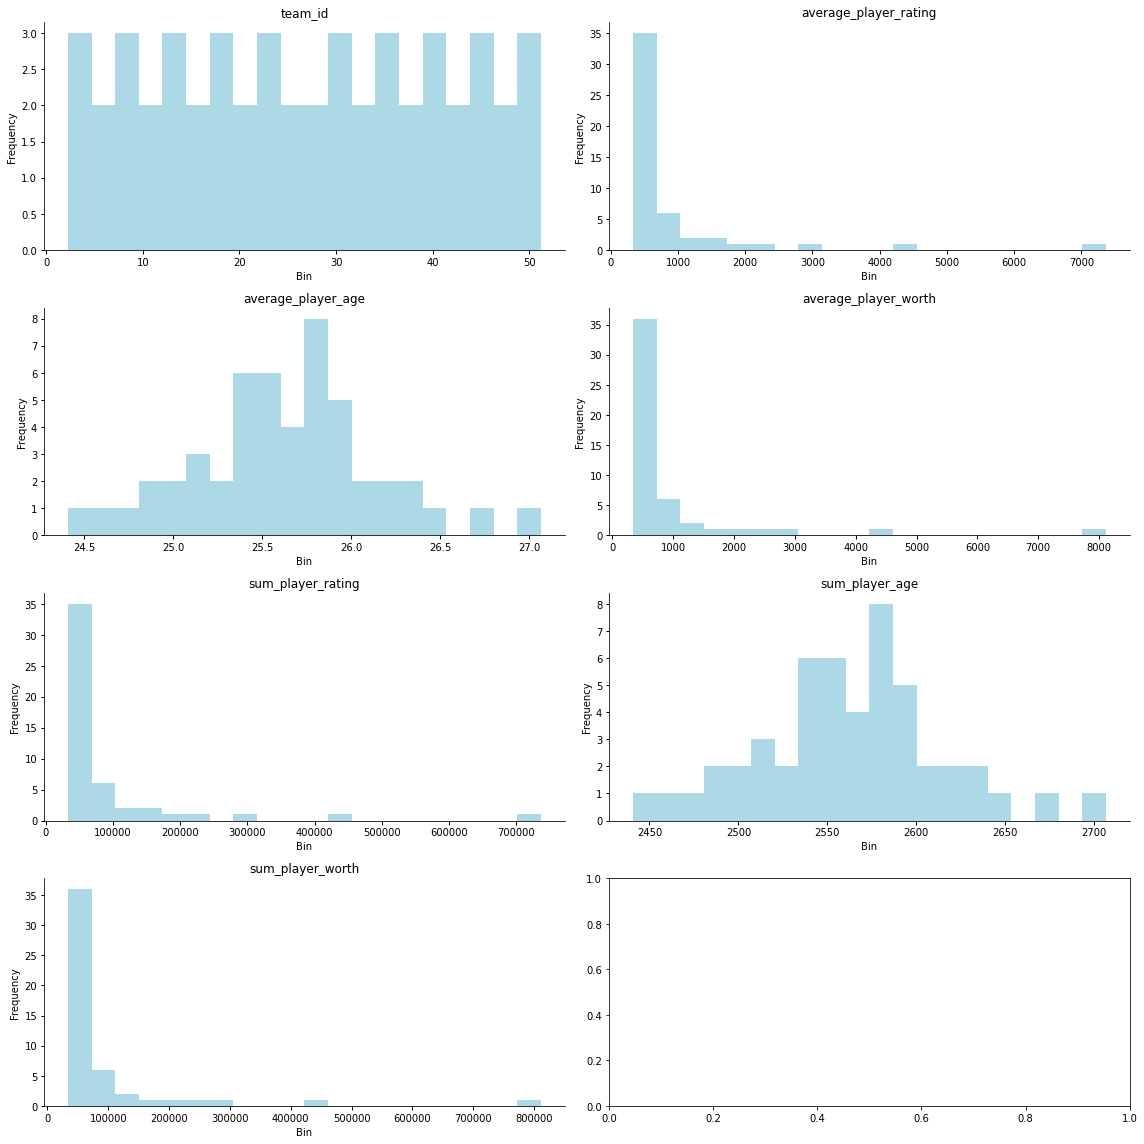

In [16]:
%%local
featurestore.visualize_featuregroup_distributions("players_features")

You can also override default parameters and configure the plotting options:

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


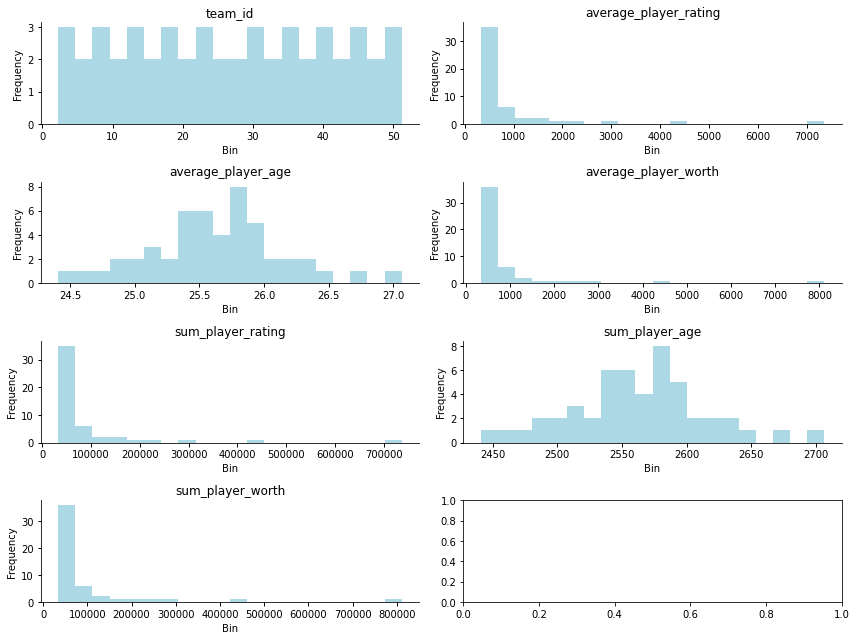

In [17]:
%%local
featurestore.visualize_featuregroup_distributions("players_features", 
                                                  featurestore=featurestore.project_featurestore(), 
                                                  featuregroup_version=1, 
                                                  figsize=(12, 9),
                                                  color='lightblue', 
                                                  log=False, 
                                                  align="center", 
                                                  plot=True)

You can also compute the figure in the spark kernel (don't have to use `%%local` then) and save it to HDFS for later viewing.

In [18]:
from hops import hdfs
fig = featurestore.visualize_featuregroup_distributions("players_features", plot=False)
fig.savefig("players_features_distributions.png")
hdfs.copy_to_hdfs("players_features_distributions.png", "Resources/", overwrite=True)

Started copying local path players_features_distributions.png to hdfs path hdfs://rpc.namenode.service.consul:8020/Projects/demo_featurestore_admin000/Resources//players_features_distributions.png

Finished copying

### Feature Correlations

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


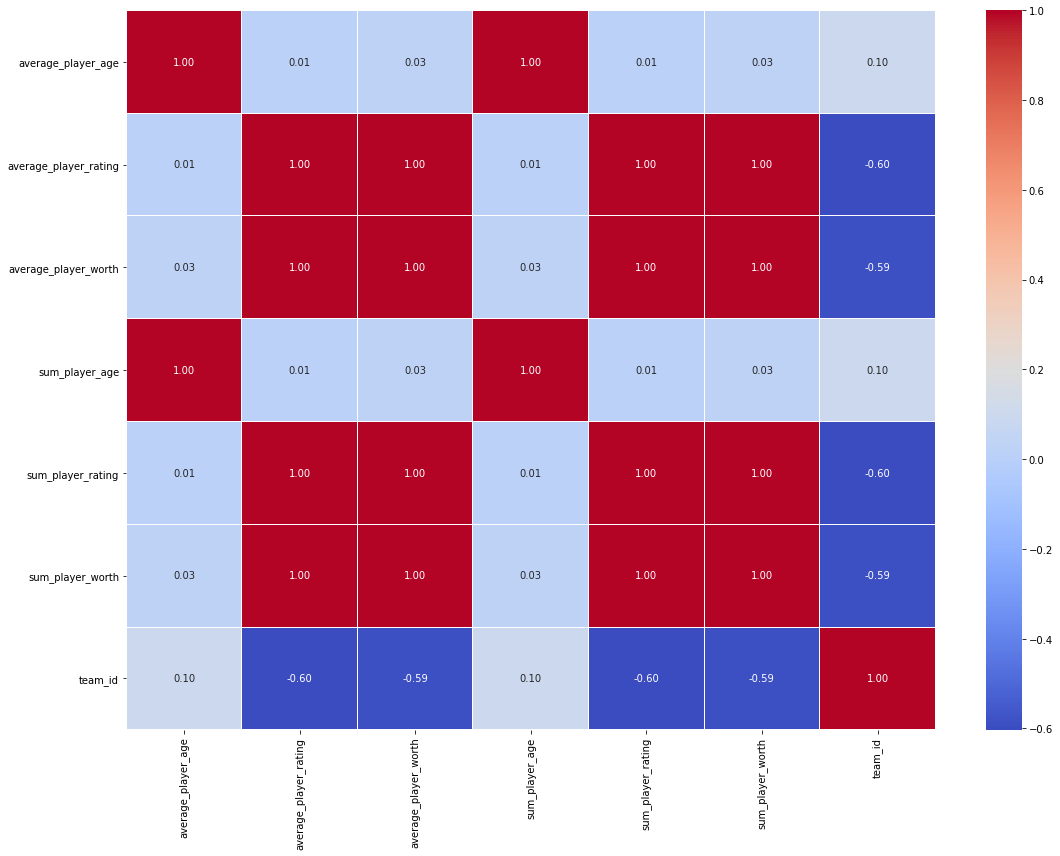

In [19]:
%%local
featurestore.visualize_featuregroup_correlations("players_features")

You can also override default parameters and configure the plotting options:

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


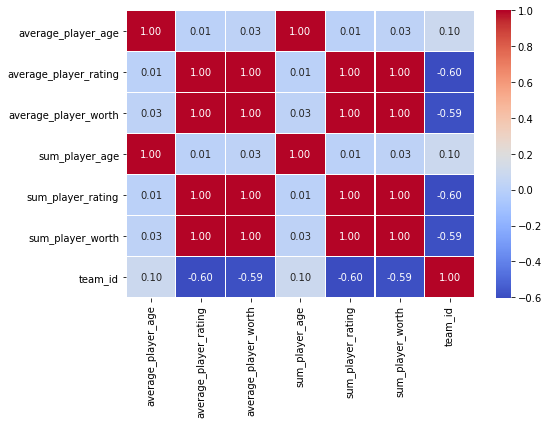

In [20]:
%%local
featurestore.visualize_featuregroup_correlations("players_features", 
                                                 featurestore=None, 
                                                 featuregroup_version=1, 
                                                 figsize=(8,6),
                                                 cmap="coolwarm", 
                                                 annot=True, 
                                                 fmt=".2f", 
                                                 linewidths=.05, 
                                                 plot=True)

You can also compute the figure in the spark kernel (don't have to use %%local then) and save it to HDFS for later viewing.

In [21]:
from hops import hdfs
fig = featurestore.visualize_featuregroup_correlations("players_features", plot=False)
fig.savefig("players_features_correlations.png")
hdfs.copy_to_hdfs("players_features_correlations.png", "Resources/", overwrite=True)

Started copying local path players_features_correlations.png to hdfs path hdfs://rpc.namenode.service.consul:8020/Projects/demo_featurestore_admin000/Resources//players_features_correlations.png

Finished copying

### Feature Clusters

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


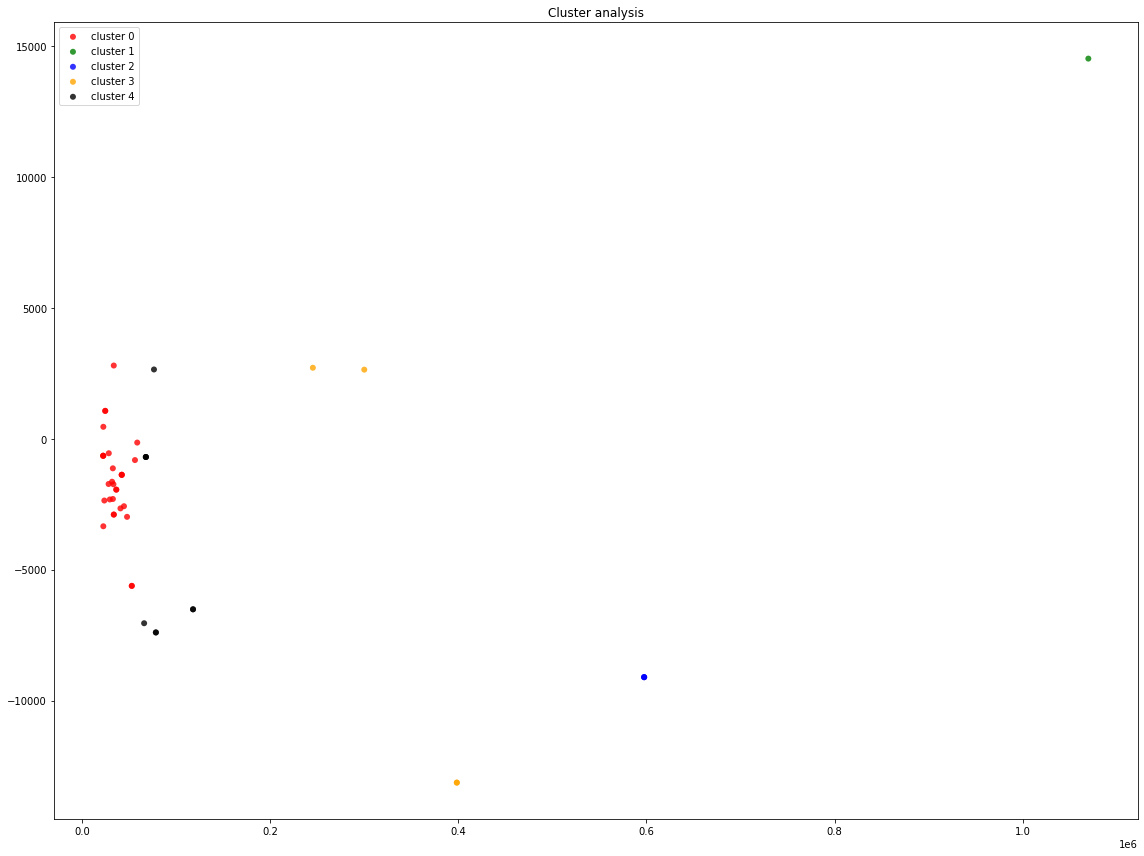

In [22]:
%%local
featurestore.visualize_featuregroup_clusters("players_features")

You can also override default parameters and configure the plotting options:

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


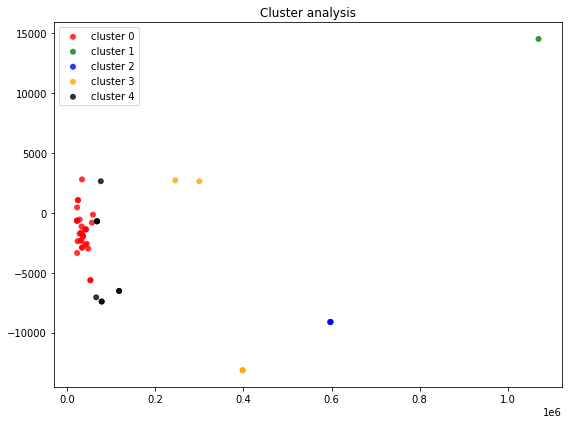

In [23]:
%%local
featurestore.visualize_featuregroup_clusters("players_features", 
                                featurestore=None, 
                                featuregroup_version=1, 
                                figsize=(8,6),
                                plot=True)

You can also compute the figure in the spark kernel (don't have to use %%local then) and save it to HDFS for later viewing.

In [24]:
from hops import hdfs
fig = featurestore.visualize_featuregroup_clusters("players_features", plot=False)
fig.savefig("players_features_clusters.png")
hdfs.copy_to_hdfs("players_features_clusters.png", "Resources/", overwrite=True)

Started copying local path players_features_clusters.png to hdfs path hdfs://rpc.namenode.service.consul:8020/Projects/demo_featurestore_admin000/Resources//players_features_clusters.png

Finished copying

### Descriptive Stats

In [25]:
%%local
desc_stats_df = featurestore.visualize_featuregroup_descriptive_stats("players_features")
desc_stats_df.head()

Output()

Since descriptive stats is just a pandas table and not a matplotlib figure it does not need a DISPLAY to work, so you can run it from the spark driver or executor as well:

In [26]:
desc_stats_df = featurestore.visualize_featuregroup_descriptive_stats("players_features")
desc_stats_df.head()

   metric  sum_player_rating  ...  sum_player_age  average_player_age
0  stddev         118708.750  ...        52.29132            0.522913
1     min          15096.327  ...      2434.00000           24.340000
2    mean          71738.375  ...      2556.84000           25.568400
3   count             50.000  ...        50.00000           50.000000
4     max         719186.300  ...      2700.00000           27.000000

[5 rows x 8 columns]

## Writing to the Feature Store


### Creating New Feature Groups

Feature Groups can be created using the Feature Store API and the `create_featuregroup()` function. Metadata of a feature group can later on be browsed and edited from the Feature Registry (UI in Hopsworks)

Lets create a new featuregroup called **teams_features_spanish** that contains the same contents as the feature group teams_features except the the columns are renamed to spanish

In [27]:
teams_features_1_df = featurestore.get_featuregroup("teams_features")

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_1 against offline feature store

In [28]:
teams_features_2_df = teams_features_1_df.withColumnRenamed(
    "team_id", "equipo_id").withColumnRenamed(
    "team_budget", "equipo_presupuesto").withColumnRenamed(
    "team_position", "equipo_posicion")

In [29]:
teams_features_2_df.show(5)

+------------------+---------+---------------+
|equipo_presupuesto|equipo_id|equipo_posicion|
+------------------+---------+---------------+
|         12957.076|        1|              1|
|         2403.3704|        2|              2|
|         3390.3755|        3|              3|
|         13547.429|        4|              4|
|          9678.333|        5|              5|
+------------------+---------+---------------+
only showing top 5 rows

Lets now create a new featuregroup using the transformed dataframe (we'll explain the statistics part later on in this notebook)

In [30]:
featurestore.create_featuregroup(
    teams_features_2_df,
    "teams_features_spanish",
    description="a spanish version of teams_features",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False
)

Registering feature metadata...
Registering feature metadata... [COMPLETE]
Writing feature data to offline feature group (Hive)...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Writing feature data to offline feature group (Hive)... [COMPLETE]
Feature group created successfully

By default the new featuregroup will be created in the project's featurestore and the statistics for the new featuregroup will be computed based on the provided spark dataframe. You can configure this behaviour by modifying the default arguments and filling in extra metadata.

In [31]:
featurestore.create_featuregroup(
    teams_features_2_df,
    "teams_features_spanish",
    description="a spanish version of teams_features",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    featurestore=featurestore.project_featurestore(),
    featuregroup_version=2
)

Registering feature metadata...
Registering feature metadata... [COMPLETE]
Writing feature data to offline feature group (Hive)...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Writing feature data to offline feature group (Hive)... [COMPLETE]
Feature group created successfully

###  Create an On-Demand Feature Group

Feature Groups in Hopsworks can be of two types: 

- **Cached Feature Groups** are pre-computed and stored inside Hopsworks as Hive tables for historical data and MySQL Cluster tables for online data.
- **On-Demand Feature Groups** are computed on-demand using a JDBC connector and a SQL query. On-Demand Feature Groups can be stored in any JDBC-compliant data store.

To create an on-demand feature group, you must first configure a storage connector ti the JDBC backend that you want to query and then you can use the method `create_on_demand_featuregroup()` to create the on-demand feature group.

By default, a Feature Store in Hopsworks has two default JDBC storage connectors configured:

- `project_name`: a storage connector for the Hive database of the project
- `project_name_featurestore a storage connector` for the Feature Store database of the project

You can list the available storage connectors in the feature store, using the method `get_storage_connectors()`

In [32]:
featurestore.get_storage_connectors()

[('demo_featurestore_admin000_featurestore', 'JDBC'), ('demo_featurestore_admin000', 'JDBC'), ('demo_featurestore_admin000_meb1_onlinefeaturestore', 'JDBC'), ('demo_featurestore_admin000_Training_Datasets', 'HOPSFS')]

If we inspect the Feature Store hive database, we can see that there is a table called `games_features_1`, lets use the JDBC connector called `<project_name>_featurestore` and the SQL string `"SELECT * FROM games_features_1 WHERE score > 1"` to create an on-demand feature group called `games_features_on_demand`. 

In [33]:
featurestore.sql("show tables").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Running sql: show tables against offline feature store
+--------------------+--------------------+-----------+
|            database|           tableName|isTemporary|
+--------------------+--------------------+-----------+
|demo_featurestore...|attendances_featu...|      false|
|demo_featurestore...|    games_features_1|      false|
|demo_featurestore...|games_features_hu...|      false|
|demo_featurestore...|  players_features_1|      false|
|demo_featurestore...|season_scores_fea...|      false|
+--------------------+--------------------+-----------+
only showing top 5 rows

In [34]:
featurestore.sql("describe games_features_1").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Running sql: describe games_features_1 against offline feature store
+------------+---------+-------+
|    col_name|data_type|comment|
+------------+---------+-------+
|away_team_id|      int|      -|
|home_team_id|      int|      -|
|       score|      int|      -|
+------------+---------+-------+

In [35]:
from hops import hdfs
query = "SELECT * FROM games_features_1 WHERE score > 1"
storage_connector = hdfs.project_name() + "_featurestore"
featuregroup_name = "games_features_on_demand"
featurestore.create_on_demand_featuregroup(query, featuregroup_name, storage_connector)

Feature group created successfully

On-Demand Feature Groups can be queried just like cached feature groups. When you query an on-demand feature group, it will open a JDBC connection and apply the associated SQL query and return the resulting dataframe.

In [36]:
featurestore.get_featuregroup("games_features_on_demand").show(5)

+------------+------------+-----+
|away_team_id|home_team_id|score|
+------------+------------+-----+
|          46|          32|    3|
|          15|          13|    2|
|          50|           1|    3|
|          36|          39|    2|
|          14|           8|    3|
+------------+------------+-----+
only showing top 5 rows

Lets create an on-demand feature group with the same JDBC connector and the table `players_features_1`, and see how we can make queries that join on-demand feature groups with cached feature groups dynamically.

In [37]:
from hops import hdfs
query = "SELECT average_player_age as average_player_age_on_dmd, average_player_worth as average_player_worth_on_dmd, team_id FROM players_features_1"
storage_connector = hdfs.project_name() + "_featurestore"
featuregroup_name = "players_features_on_demand"
featurestore.create_on_demand_featuregroup(query, featuregroup_name, storage_connector)

Feature group created successfully

When you make a query to the feature store that cross multiple feature groups, including on-demand feature groups. The Query Planner that comes with the Python SDK will first fetch the on-demand feature groups and then register them as SparkSQL temporary tables, before joining them with the features from the cached feature groups.

Note that when querying on-demand-featuregroups, you typically have to supply the `join_key` and the `featuregroups_version_dict` manually as the query planner will often not have information about the columns in the on-demand feature groups and hence cannot infer the join key or infer in which on-demand feature group a certain feature exists.

In [ ]:
featurestore.get_features(["average_player_age_on_dmd", "average_player_worth_on_dmd", "average_attendance", 
                           "sum_attendance"],
                         featuregroups_version_dict={
                             "players_features_on_demand": 1, 
                             "attendances_features": 1
                         }, join_key="team_id").show(5)

In [39]:
featurestore.get_feature("average_player_age_on_dmd", featuregroup="players_features_on_demand").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 1 feature from the featurestore created successfully
Registered on-demand feature group: players_features_on_demand with version: 1 as temporary table: players_features_on_demand_1
SQL string for the query created successfully
Running sql: SELECT average_player_age_on_dmd FROM players_features_on_demand_1 against offline feature store
+-------------------------+
|average_player_age_on_dmd|
+-------------------------+
|                    24.63|
|                    25.71|
|                    25.63|
|                    25.65|
|                     25.5|
+-------------------------+
only showing top 5 rows

###  Create a New Version of A Feature Group

To create a new version, simply use the `create_featuregroup` method and specify the version argument:

In [40]:
featurestore.create_featuregroup(
    teams_features_2_df,
    "teams_features_spanish",
    description="a spanish version of teams_features",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    featuregroup_version=3
)

Registering feature metadata...
Registering feature metadata... [COMPLETE]
Writing feature data to offline feature group (Hive)...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Writing feature data to offline feature group (Hive)... [COMPLETE]
Feature group created successfully

#### Get the Latest Version of a Feature Group (0 if no version exist)

In [41]:
latest_version = featurestore.get_latest_featuregroup_version("teams_features_spanish")
latest_version

3

#### Update Metadata Cache

Note: By default, the python client will only fetch the featurestore metadata once and then cache it on the client. If you need to update the cache you can use the command:

In [42]:
featurestore.get_featurestore_metadata(update_cache=True)

### Featuregroup Partitioning 

Cached Featuregroups are stored as Hive tables, meaning that they can be partitioned for improved **read-query** performance. We use dynamic partitioning where the partition keys are specified on creation of a featuregroup. To set the partitions, simply specify the `partition_by` argument to `create_featuregroup()`. The `partition_by` argument should be set as a python list of the columns that you want to partition the table on, see examples below.

Partitioning is not supported for training datasets as those are meant to be immutable blobs used for training (e.g petastorm or tfrecords), and do not need to be optimized for query performance. 

Feature groups in Hive might need to be read-query optimized however, since it might be used to create a lot of different training datasets, using different subsets of features.

As an example we can take the `games_features` featuregroup created by the featurestore tour and re-create it as a new featuregroup called `games_features_partitioned` where we partition on the `score` column.

In [43]:
games_features_df = featurestore.get_featuregroup("games_features")

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM games_features_1 against offline feature store

In [44]:
featurestore.create_featuregroup(
    games_features_df,
    "games_features_partitioned",
    description="games_features partitioned by score",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    partition_by=["score"]
)

Registering feature metadata...
Registering feature metadata... [COMPLETE]
Writing feature data to offline feature group (Hive)...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Writing feature data to offline feature group (Hive)... [COMPLETE]
Feature group created successfully

We can also partition on multiple columns (watch out so that the number of partitions don't get too many though). Also note that it is not allowed to partition on the primary key, which does not make sense either since the primary key should be unique. If you try to partition on the primary key, the partitioning will simply be skipped. 

In [45]:
featurestore.create_featuregroup(
    games_features_df,
    "games_features_double_partitioned",
    description="games_features partitioned by score and away_team_id",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    partition_by=["score", "home_team_id"]
)

Registering feature metadata...
Registering feature metadata... [COMPLETE]
Writing feature data to offline feature group (Hive)...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Writing feature data to offline feature group (Hive)... [COMPLETE]
Feature group created successfully

To verify the partitions we can use the utility function `get_featuregroup_partitions`:

In [46]:
featurestore.get_featuregroup_partitions("games_features_partitioned").show(10)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Running sql: SHOW PARTITIONS games_features_partitioned_1 against offline feature store
+---------+
|partition|
+---------+
|  score=1|
|  score=2|
|  score=3|
+---------+

In [47]:
featurestore.get_featuregroup_partitions("games_features_double_partitioned").show(10)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Running sql: SHOW PARTITIONS games_features_double_partitioned_1 against offline feature store
+--------------------+
|           partition|
+--------------------+
|home_team_id=1/sc...|
|home_team_id=1/sc...|
|home_team_id=10/s...|
|home_team_id=10/s...|
|home_team_id=10/s...|
|home_team_id=11/s...|
|home_team_id=11/s...|
|home_team_id=11/s...|
|home_team_id=12/s...|
|home_team_id=12/s...|
+--------------------+
only showing top 10 rows

You can also specify the optional arguments for `get_featuregroup_partitions`:

In [48]:
featurestore.get_featuregroup_partitions("games_features_partitioned",
                                         featurestore=featurestore.project_featurestore(),
                                         featuregroup_version = 1,
                                         dataframe_type="spark").show(10)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Running sql: SHOW PARTITIONS games_features_partitioned_1 against offline feature store
+---------+
|partition|
+---------+
|  score=1|
|  score=2|
|  score=3|
+---------+

When you overwrite a table, it will pick up the old partitioning scheme it had before the overwrite: 

In [49]:
featurestore.insert_into_featuregroup(games_features_df, "games_features_partitioned", mode="overwrite")

Inserting data into offline feature group games_features_partitioned...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Inserting data into offline feature group games_features_partitioned... [COMPLETE]
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM games_features_partitioned_1 against offline feature store
Insertion into feature group was successful

In [50]:
featurestore.get_featuregroup_partitions("games_features_partitioned").show(10)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Running sql: SHOW PARTITIONS games_features_partitioned_1 against offline feature store
+---------+
|partition|
+---------+
|  score=1|
|  score=2|
|  score=3|
+---------+

### Synchronize a Hive Table with the Feature Store

The Feature Store SDK supports method for synchronizing existing Hive tables with the feature store, using `syncHiveTableWithFeaturestore`

Create an example Hive Table (praxis in the feature store is to have `_version` suffix on the table):

In [51]:
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, LongType, IntegerType, FloatType
sqlContext = SQLContext(sc)
schema = StructType([StructField("equipo_id", IntegerType(), True),
                     StructField("equipo_presupuesto", FloatType(), True),
                     StructField("equipo_posicion", IntegerType(), True)
                        ])
sample_df = sqlContext.createDataFrame([(999, 41251.52, 1), (998, 1319.4, 8), (997, 21219.1, 2)], schema)
spark.sql("use {}".format(featurestore.project_featurestore()))
sample_df.write.mode("overwrite").saveAsTable("hive_fs_sync_example_1")

In [52]:
spark.sql("show tables").show(20, False)

+---------------------------------------+-----------------------------------+-----------+
|database                               |tableName                          |isTemporary|
+---------------------------------------+-----------------------------------+-----------+
|demo_featurestore_admin000_featurestore|attendances_features_1             |false      |
|demo_featurestore_admin000_featurestore|games_features_1                   |false      |
|demo_featurestore_admin000_featurestore|games_features_double_partitioned_1|false      |
|demo_featurestore_admin000_featurestore|games_features_hudi_tour_1         |false      |
|demo_featurestore_admin000_featurestore|games_features_partitioned_1       |false      |
|demo_featurestore_admin000_featurestore|hive_fs_sync_example_1             |false      |
|demo_featurestore_admin000_featurestore|players_features_1                 |false      |
|demo_featurestore_admin000_featurestore|season_scores_features_1           |false      |
|demo_feat

In [53]:
featurestore.sync_hive_table_with_featurestore("hive_fs_sync_example", 
                                               description="test Hive sync", 
                                               featuregroup_version=1)

Synchronizing Hive Table: hive_fs_sync_example with Feature Store: demo_featurestore_admin000_featurestore
Hive Table: hive_fs_sync_example was successfully synchronized with Feature Store: demo_featurestore_admin000_featurestore

In [54]:
featurestore.get_featuregroups()

['attendances_features_1', 'games_features_1', 'games_features_double_partitioned_1', 'games_features_hudi_tour_1', 'games_features_on_demand_1', 'games_features_on_demand_tour_1', 'games_features_partitioned_1', 'hive_fs_sync_example_1', 'players_features_1', 'players_features_on_demand_1', 'season_scores_features_1', 'teams_features_1', 'teams_features_spanish_1', 'teams_features_spanish_2', 'teams_features_spanish_3']

In [55]:
featurestore.get_featuregroup("hive_fs_sync_example").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM hive_fs_sync_example_1 against offline feature store
+---------+---------------+------------------+
|equipo_id|equipo_posicion|equipo_presupuesto|
+---------+---------------+------------------+
|      998|              8|            1319.4|
|      997|              2|           21219.1|
|      999|              1|          41251.52|
+---------+---------------+------------------+

### Inserting Into Existing Feature Groups

A best practice when working with features in HopsML is to first figure out a model of feature groups and create them  using the Feature Registry UI. This will prepare the feature group schema and create the Hive tables. Once the empty feature groups are created, then you can insert into these tables directly.

Lets first get some sample data to insert

In [56]:
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, LongType, IntegerType, FloatType
sqlContext = SQLContext(sc)

In [57]:
schema = StructType([StructField("equipo_id", IntegerType(), True),
                     StructField("equipo_presupuesto", FloatType(), True),
                     StructField("equipo_posicion", IntegerType(), True)
                        ])
sample_df = sqlContext.createDataFrame([(999, 41251.52, 1), (998, 1319.4, 8), (997, 21219.1, 2)], schema)

In [58]:
sample_df.show(5)

+---------+------------------+---------------+
|equipo_id|equipo_presupuesto|equipo_posicion|
+---------+------------------+---------------+
|      999|          41251.52|              1|
|      998|            1319.4|              8|
|      997|           21219.1|              2|
+---------+------------------+---------------+

In [59]:
sample_df.count()

3

Lets inspect the contents of the featuregroup `teams_features_spanish` that we are going to insert the sample data into:

In [60]:
spanish_team_features_df = featurestore.get_featuregroup(
    "teams_features_spanish")

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_spanish_1 against offline feature store

In [61]:
spanish_team_features_df.show(5)

+---------+---------------+------------------+
|equipo_id|equipo_posicion|equipo_presupuesto|
+---------+---------------+------------------+
|        1|              1|         12957.076|
|        2|              2|         2403.3704|
|        3|              3|         3390.3755|
|        4|              4|         13547.429|
|        5|              5|          9678.333|
+---------+---------------+------------------+
only showing top 5 rows

In [62]:
spanish_team_features_df.count()

50

Now we can insert the sample data and verify the new contents of the featuregroup. By default the insert mode is "append", the featurestore is the project's featurestore, the version is 1 and statistics will be updated based on the previously made settings when the featuregroup was created (we cover statistics later on in this notebook).

In [63]:
featurestore.insert_into_featuregroup(
    sample_df, 
    "teams_features_spanish"
)

Inserting data into offline feature group teams_features_spanish...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Inserting data into offline feature group teams_features_spanish... [COMPLETE]
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_spanish_1 against offline feature store
Insertion into feature group was successful

Lets now inspect the contents of the feature group to verify that the insertion was successful

In [64]:
spanish_team_features_df_updated = featurestore.get_featuregroup(
    "teams_features_spanish")

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_spanish_1 against offline feature store

In [65]:
spanish_team_features_df_updated.show(5)

+---------+---------------+------------------+
|equipo_id|equipo_posicion|equipo_presupuesto|
+---------+---------------+------------------+
|        1|              1|         12957.076|
|        2|              2|         2403.3704|
|        3|              3|         3390.3755|
|        4|              4|         13547.429|
|        5|              5|          9678.333|
+---------+---------------+------------------+
only showing top 5 rows

In [66]:
spanish_team_features_df_updated.count()

53

You can also explicitly specify featurestore, featuregroup version and the insert mode:

In [67]:
featurestore.insert_into_featuregroup(
    sample_df, 
    "teams_features_spanish", 
    featurestore=featurestore.project_featurestore(), 
    featuregroup_version=1, 
    mode="append"
)

Inserting data into offline feature group teams_features_spanish...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Inserting data into offline feature group teams_features_spanish... [COMPLETE]
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_spanish_1 against offline feature store
Insertion into feature group was successful

In [68]:
featurestore.get_featuregroup("teams_features_spanish").count()

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_spanish_1 against offline feature store
56

The two supported insert modes are "append" and "overwrite"

In [69]:
featurestore.insert_into_featuregroup(
    sample_df, 
    "teams_features_spanish",
    mode="overwrite")

Inserting data into offline feature group teams_features_spanish...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Inserting data into offline feature group teams_features_spanish... [COMPLETE]
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_spanish_1 against offline feature store
Insertion into feature group was successful

In [70]:
featurestore.get_featuregroup("teams_features_spanish").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_spanish_1 against offline feature store
+---------+---------------+------------------+
|equipo_id|equipo_posicion|equipo_presupuesto|
+---------+---------------+------------------+
|      999|          41251|               1.0|
|      998|           1319|               8.0|
|      997|          21219|               2.0|
+---------+---------------+------------------+

In [71]:
featurestore.get_featuregroup("teams_features_spanish").count()

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_spanish_1 against offline feature store
3

### Import External Feature Datasets to the Feature Store

Feature datasets stored externally to Hopsworks can be imported using the `import_featuregroup` primitive in the Featurestore SDK. For example, say that you have a dataset stored on S3 that you want to import. To import the dataset from S3, first configure an s3 connector for your feature store, e.g with name `my_s3_connector`. The connector is used for authenticating with S3 and for specifying your bucket name. Once the connector is configured, you can use the `import_featuregroup` function as follows:
```python
from hops import featurestore
featurestore.import_featuregroup("my_s3_connector", s3_bucket_path, "fg_name", data_format="tfrecords")
```

## Integrating the Feature Store with Pandas and Numpy

The Hops Feature Store works natively with Spark, but you can easily connect it to your numpy/pandas/pure python pipelines as well (just recall that if you are working with big data, using libraries like numpy/pandas that are not distributed will not scale.

In [72]:
import pandas as pd
import numpy as np
import datetime
import time

### Read Features from the Featue Store into a Pandas or Numpy Table

To read from the feature store into pandas and numpy we just have to specify the optional argument `dataframe_type` that defaults to "spark". This argument decides the format of the returning dataframe. If you want the features returned to be in either pandas or numpy format you can specfy `dataframe_type='pandas'` or `dataframe_type='numpy'`.

#### Reading Features into a Pandas Dataframe

In [73]:
pandas_df = featurestore.get_features(["team_budget", "average_attendance", "average_player_age"], 
                                      dataframe_type="pandas")

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT average_player_age, team_budget, average_attendance FROM players_features_1 JOIN teams_features_1 JOIN attendances_features_1 ON players_features_1.`team_id`=teams_features_1.`team_id` AND players_features_1.`team_id`=attendances_features_1.`team_id` against offline feature store

In [74]:
pandas_df.head()

   average_player_age   team_budget  average_attendance
0           24.629999  12514.561523         3587.501465
1           25.709999   1587.089722         2532.163818
2           25.629999   3839.075439         3397.806641
3           25.650000  16758.066406         3271.934082
4           25.500000   3966.359131         4074.804688

#### Reading Features into a Numpy 2D Array

In [75]:
numpy_df = featurestore.get_features(["team_budget", "average_attendance", "average_player_age"], 
                                      dataframe_type="numpy")

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT average_player_age, team_budget, average_attendance FROM players_features_1 JOIN teams_features_1 JOIN attendances_features_1 ON players_features_1.`team_id`=teams_features_1.`team_id` AND players_features_1.`team_id`=attendances_features_1.`team_id` against offline feature store

In [76]:
numpy_df.shape

(50, 3)

#### Reading Features into a Python 2D List

In [77]:
python_df = featurestore.get_features(["team_budget", "average_attendance", "average_player_age"], 
                                      dataframe_type="python")

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT average_player_age, team_budget, average_attendance FROM players_features_1 JOIN teams_features_1 JOIN attendances_features_1 ON players_features_1.`team_id`=teams_features_1.`team_id` AND players_features_1.`team_id`=attendances_features_1.`team_id` against offline feature store

In [78]:
len(python_df)

50

In [79]:
len(python_df[0])

3

### Write Pandas or Numpy Tables into the Feature Store

The feature store API natively supports dataframes in spark, pandas, python or numpy format for writing to the feature store. 

**Note** that since the feature store contains feature groups with documented schemas to allow easy joining of thousands of features in the future, inserting raw numpy arrays is not recommended. Numpy arrays and python lists do not have any associated schema so the library will infer the schema to be "col_1, col_2, col_3... etc". It is recommended that you think carefully in how to model your feature schema with naming of columns **before** you insert into the feature store so that it becomed easy to later join features across several feature groups by using a common join-column.

#### Writing a Pandas DataFrame to the Feature Store

In [80]:
pandas_df.columns

Index(['average_player_age', 'team_budget', 'average_attendance'], dtype='object')

In [81]:
# Let's rename the columns to differentiate this feature group from existing ones in the feature store
pandas_df.columns = ["average_player_age_test", "team_budget_test", "average_attendance_test"]

In [82]:
featurestore.create_featuregroup(
    pandas_df,
    "pandas_test_example",
    description="test featuregroup created from pandas dataframe",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False
)

Registering feature metadata...
Registering feature metadata... [COMPLETE]
Writing feature data to offline feature group (Hive)...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Writing feature data to offline feature group (Hive)... [COMPLETE]
Feature group created successfully

In [83]:
# All insert/create methods in the API supports spark, pandas, and numpy dataframes
featurestore.insert_into_featuregroup(
    pandas_df, 
    "pandas_test_example",
    mode="overwrite")

Inserting data into offline feature group pandas_test_example...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Inserting data into offline feature group pandas_test_example... [COMPLETE]
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM pandas_test_example_1 against offline feature store
Insertion into feature group was successful

#### Writing a Numpy 2D Array to the Feature Store

In [84]:
featurestore.create_featuregroup(
    numpy_df,
    "numpy_test_example",
    description="test featuregroup created from numpy matrix",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False
)

Registering feature metadata...
Registering feature metadata... [COMPLETE]
Writing feature data to offline feature group (Hive)...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Writing feature data to offline feature group (Hive)... [COMPLETE]
Feature group created successfully

As Numpy arrays do not have an associated schema the resulting feature group will have default column names. A best practice if you are working with numpy is to convert it to a pandas or spark dataframe and specify an explicit schema before you save it to the feature store.

In [85]:
featurestore.get_featuregroup("numpy_test_example", dataframe_type="spark").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM numpy_test_example_1 against offline feature store
+------------------+------------------+-----------------+
|             col_0|             col_1|            col_2|
+------------------+------------------+-----------------+
|  24.6299991607666|  12514.5615234375| 3587.50146484375|
|25.709999084472656|1587.0897216796875|2532.163818359375|
|  25.6299991607666| 3839.075439453125|   3397.806640625|
|25.649999618530273|    16758.06640625| 3271.93408203125|
|              25.5| 3966.359130859375|     4074.8046875|
+------------------+------------------+-----------------+
only showing top 5 rows

In [86]:
# All insert/create methods in the API supports spark, pandas, and numpy dataframes
featurestore.insert_into_featuregroup(
    numpy_df, 
    "numpy_test_example",
    mode="overwrite")

Inserting data into offline feature group numpy_test_example...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Inserting data into offline feature group numpy_test_example... [COMPLETE]
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM numpy_test_example_1 against offline feature store
Insertion into feature group was successful

#### Writing a Python 2D List to the Feature Store

In [87]:
featurestore.create_featuregroup(
    python_df,
    "python_test_example",
    description="test featuregroup created from python 2D list",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False
)

Registering feature metadata...
Registering feature metadata... [COMPLETE]
Writing feature data to offline feature group (Hive)...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Writing feature data to offline feature group (Hive)... [COMPLETE]
Feature group created successfully

In [88]:
# All insert/create methods in the API supports spark, pandas, and numpy dataframes
featurestore.insert_into_featuregroup(
    python_df, 
    "python_test_example",
    mode="overwrite")

Inserting data into offline feature group python_test_example...
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Inserting data into offline feature group python_test_example... [COMPLETE]
Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM python_test_example_1 against offline feature store
Insertion into feature group was successful

As python lists do not have an associated schema the resulting feature group will have default column names. A best practice if you are working with python lists is to convert it to a pandas or spark dataframe and specify an explicit schema before you save it to the feature store

In [89]:
featurestore.get_featuregroup("python_test_example", dataframe_type="spark").show(5)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM python_test_example_1 against offline feature store
+------------------+------------------+-----------------+
|             col_0|             col_1|            col_2|
+------------------+------------------+-----------------+
|  24.6299991607666|  12514.5615234375| 3587.50146484375|
|25.709999084472656|1587.0897216796875|2532.163818359375|
|  25.6299991607666| 3839.075439453125|   3397.806640625|
|25.649999618530273|    16758.06640625| 3271.93408203125|
|              25.5| 3966.359130859375|     4074.8046875|
+------------------+------------------+-----------------+
only showing top 5 rows

## Feature Group Statistics

Statistics about a featuregroup can be useful in the stage of feature engineering and when deciding which features to use for training. If statistics have been computed for a feature group, it can be viewed in the Hopsworks Feature Registry UI. 

This is particularly useful within large organizations where data scientists from different teams can re-use and explore new features by browsing features in the feature store and analyzing the statistics.

![Feature Registry Statistics Visualization](./images/fg_stats_1.png "Feature Registry Statistics Visualization")

As you might have notived earlier in this notebook, the `create_featuregroup` method has arguments for configuring the statistics to be computed as data is added. These settings will be saved along with the rest of the meta data about the featuregroup and will be applied when new data is inserted into the featuregroup using the `insert_into_featuregroup` method.

You can use the `update_featuregroup_stats()` method to update the settings for the statistics of a feature group and recompute the statistics without inserting any new data. By default it will compute the statistics based on the previous settings, use the project's featurestore and use version 1 of the featuregroup:

In [90]:
featurestore.update_featuregroup_stats("teams_features")

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_1 against offline feature store
computing descriptive statistics for : teams_features, version: 1
computing feature correlation for: teams_features, version: 1
computing feature histograms for: teams_features, version: 1
computing cluster analysis for: teams_features, version: 1

You can also be explicitly specify featuregroup details and what statistics to compute, this will also update the settings for future inserts:

In [91]:
featurestore.update_featuregroup_stats(
    "teams_features", 
    featuregroup_version=1, 
    featurestore=featurestore.project_featurestore(), 
    descriptive_statistics=True,
    feature_correlation=True, 
    feature_histograms=True,
    cluster_analysis=True,
    stat_columns=None)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_1 against offline feature store
computing descriptive statistics for : teams_features, version: 1
computing feature correlation for: teams_features, version: 1
computing feature histograms for: teams_features, version: 1
computing cluster analysis for: teams_features, version: 1

If you only want to compute statistics for certain set of columns and exclude surrogate key-columns for example, you can use the optional argument `stat_columns` to specify which columns to include:

In [92]:
featurestore.update_featuregroup_stats(
    "teams_features", 
    featuregroup_version=1, 
    featurestore=featurestore.project_featurestore(), 
    descriptive_statistics=True,
    feature_correlation=True, 
    feature_histograms=True,
    cluster_analysis=True,
    stat_columns=['team_budget', 'team_position'])

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_1 against offline feature store
computing descriptive statistics for : teams_features, version: 1
computing feature correlation for: teams_features, version: 1
computing feature histograms for: teams_features, version: 1
computing cluster analysis for: teams_features, version: 1

## Training Datasets

To group data in the feature store we use three concepts:

- Feature
- Feature group
- Training Dataset

Typically during the feature engineering phase of a machine learning project, you compute a set of features for each type of data that you have, these features are naturally grouped into a documented and versioned **feature group**. 

In practice, it is common that organizations have many different type of datasets that they can extract features from, for example if you are building a recommendation system you might have demographic data about each user as well as user-activity data. 

When you train a machine learning model, you want to use all features that have predictive power and that the model can learn from. At this point, we can create a training dataset of features from several different feature groups and use that for training. That is the purpose of the training dataset abstraction. 

Of course you can always just save a group of features anywhere inside your project, e.g as a csv, or .tfrecords file. However, by using the feature store you can create **managed** training datasets. Managed training datasets will show up in the feature registry UI and will automatically be versioned, documented and reproducible. 

The training datasets in a project are stored in a top-level dataset called `<ProjectName>_Training_Datasets`, (i.e `hdfs:///Projects/<ProjectName>/<ProjectName>_Training_Datasets`.

Once a training dataset have been created you can find it in the featurestore UI in hopsworks under the tab `Training datasets`, from there you can also edit the metadata if necessary. 

After a training dataset have been created with the necessary metadata you can save the actual data in the training dataset by using the API function `insert_into_training_dataset`.

### Create New Training Dataset

Lets create a dataset called `team_position_prediction` by using a set of relevant features from the featurestore. We will combine features from four different feature groups to form this training dataset: `teams_features`, `attendances_features`, `players_features`, `season_scores_features`.

#### Read Features

In [93]:
features_df = featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age",
    "team_position", "sum_attendance", 
     "average_player_rating", "average_player_worth", "sum_player_age",
     "sum_player_rating", "sum_player_worth", "sum_position", 
     "average_position"
    ]
)

Running sql: use demo_featurestore_admin000_featurestore against offline feature store
Logical query plan for getting 12 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT team_budget, average_position, sum_player_rating, average_attendance, average_player_worth, sum_player_worth, sum_position, sum_attendance, average_player_rating, team_position, sum_player_age, average_player_age FROM teams_features_1 JOIN season_scores_features_1 JOIN players_features_1 JOIN attendances_features_1 ON teams_features_1.`team_id`=season_scores_features_1.`team_id` AND teams_features_1.`team_id`=players_features_1.`team_id` AND teams_features_1.`team_id`=attendances_features_1.`team_id` against offline feature store

In [94]:
features_df.show(5)

+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|team_budget|average_position|sum_player_rating|average_attendance|average_player_worth|sum_player_worth|sum_position|sum_attendance|average_player_rating|team_position|sum_player_age|average_player_age|
+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|  12514.562|            59.4|        24030.572|         3587.5015|            231.8708|        23187.08|      1188.0|      71750.03|            240.30573|           31|        2463.0|             24.63|
|  1587.0897|           60.65|        24039.303|         2532.1638|           223.71338|       22371.338|      1213.0|     50643.277|            240.39302|           34|        2571.0|

#### Get the Latest Version of a Training Dataset (0 if no version exist)

In [95]:
latest_version = featurestore.get_latest_training_dataset_version("team_position_prediction")
latest_version

0

#### Save a Training Dataset in TFRecords Format

Now we can create a training dataset from the dataframe with some extended metadata such as schema (automatically inferred). By default when you create a training dataset it will be in "tfrecords" format and statistics will be computed for all features. After the dataset have been created you can view and/or update the metadata about the training dataset from the Hopsworks featurestore UI

In [96]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    training_dataset_version = latest_version + 1
)

write feature frame, write_mode: overwrite
Training Dataset created successfully

You can override the default configuration if necessary:

Supported data formats are:

- csv (written with spark distributed)
- tsv (written with spark distributed)
- parquet (written with spark distributed)
- tfrecords (written with spark distributed)
- avro (written with spark distributed)
- orc (written with spark distributed)
- hdf5 (written with single-machine, must fit into memory)
- npy (written with single-machine, must fit into memory)
- petastorm (written with spark distributed)

#### Save a Training Dataset in  CSV format

In [97]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_csv",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="csv",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_csv") + 1,
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

Training Dataset created successfully

#### Save a Training Dataset in  TSV format

In [98]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_tsv",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="tsv",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_tsv") + 1,
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

Training Dataset created successfully

#### Save a Training Dataset in Parquet format

In [99]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_parquet",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="parquet",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_parquet") + 1,
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

Training Dataset created successfully

#### Save a Training Dataset in ORC format

In [100]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_orc",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="orc",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_orc") + 1,
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

Training Dataset created successfully

#### Save a Training Dataset in avro format

In [101]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_avro",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="avro",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_avro") + 1,
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

Training Dataset created successfully

#### Save a Training Dataset in HDF5 format

In [102]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_hdf5",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="hdf5",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_hdf5") + 1,
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

Training Dataset created successfully
/srv/hops/anaconda/anaconda/envs/python36/lib/python3.6/site-packages/hops/featurestore_impl/featureframes/FeatureFrame.py:464: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf5_file = h5py.File(tf)

#### Save a Training Dataset in  .npy format

In [103]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_npy",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="npy",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_npy") + 1,
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

Training Dataset created successfully

#### Save a Training Dataset in petastorm format

Petastorm requires an explicit **Unischema** that can be pased to `create_training_dataset` with the optional argument `petastorm_args` that contain a dict of petastorm arguments.

In [104]:
from petastorm.unischema import dict_to_spark_row, Unischema, UnischemaField
from petastorm.codecs import ScalarCodec, CompressedImageCodec, NdarrayCodec
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
import numpy as np
features_df.printSchema()

root
 |-- team_budget: float (nullable = true)
 |-- average_position: float (nullable = true)
 |-- sum_player_rating: float (nullable = true)
 |-- average_attendance: float (nullable = true)
 |-- average_player_worth: float (nullable = true)
 |-- sum_player_worth: float (nullable = true)
 |-- sum_position: float (nullable = true)
 |-- sum_attendance: float (nullable = true)
 |-- average_player_rating: float (nullable = true)
 |-- team_position: integer (nullable = true)
 |-- sum_player_age: float (nullable = true)
 |-- average_player_age: float (nullable = true)

In [105]:
PetastormSchema = Unischema('team_position_prediction_petastorm_schema', [
    UnischemaField('team_budget', np.float32, (), ScalarCodec(FloatType()), False),
    UnischemaField('average_position', np.float32, (), ScalarCodec(FloatType()), False),
    UnischemaField('sum_player_rating', np.float32, (), ScalarCodec(FloatType()), False),
    UnischemaField('average_attendance', np.float32, (), ScalarCodec(FloatType()), False),
    UnischemaField('average_player_worth', np.float32, (), ScalarCodec(FloatType()), False),
    UnischemaField('sum_player_worth', np.float32, (), ScalarCodec(FloatType()), False),
    UnischemaField('sum_position', np.float32, (), ScalarCodec(FloatType()), False),
    UnischemaField('average_player_rating', np.float32, (), ScalarCodec(FloatType()), False),
    UnischemaField('team_position', np.int32, (), ScalarCodec(IntegerType()), False),
    UnischemaField('sum_player_age', np.float32, (), ScalarCodec(FloatType()), False),
    UnischemaField('average_player_age', np.float32, (), ScalarCodec(FloatType()), False),
])

petastorm_args = {
    "schema": PetastormSchema
}

In [106]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_petastorm",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="petastorm",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_petastorm") + 1,
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None,
    petastorm_args=petastorm_args
)

Training Dataset created successfully

###  Create a New Version of A Training Dataset

To create a new version, simply use the `create_training_dataset` method and specify the version argument:

In [107]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction") + 1,
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False)

write feature frame, write_mode: overwrite
Training Dataset created successfully

### Inserting Into an Existing Training Dataset

Once a dataset have been created, its metadata is browsable in the featurestore registry in the Hopsworks UI. If you don't want to create a new training dataset but just overwrite or insert new data into an existing training dataset, you can use the API function `insert_into_training_dataset`. 

In [108]:
featurestore.insert_into_training_dataset(
    features_df, 
    "team_position_prediction_csv",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_csv")
)

insert_into_training_dataset
Writing Feature Frame, data format: csv
Insertion into training dataset was successful

By default the `insert_into_training_dataset` will use the project's featurestore, overwrite semantics, version 1 of the training dataset, and update the training dataset statistics, this configuration can be overridden.

**Note**: "append" write mode is not supported for training datasets stored in tfrecords format, only "overwrite".

In [109]:
featurestore.insert_into_training_dataset(
    features_df,
    "team_position_prediction_csv",
    featurestore=featurestore.project_featurestore(),
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None,
    write_mode="overwrite",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_csv")
)

insert_into_training_dataset
Writing Feature Frame, data format: csv
Insertion into training dataset was successful

### Get Training Dataset Path

After a **managed dataset** have been created, it is easy to share it and re-use it for training various models. For example if the dataset have been materialized in tf-records format you can call the method `get_training_dataset_path(training_dataset)` to get the HDFS path and read it directly in your tensorflow code.

In [110]:
featurestore.get_training_dataset_path("team_position_prediction_csv")

'hdfs://rpc.namenode.service.consul:8020/Projects/demo_featurestore_admin000/demo_featurestore_admin000_Training_Datasets/team_position_prediction_csv_1/team_position_prediction_csv'

In [111]:
featurestore.get_training_dataset_path("team_position_prediction_hdf5")

'hdfs://rpc.namenode.service.consul:8020/Projects/demo_featurestore_admin000/demo_featurestore_admin000_Training_Datasets/team_position_prediction_hdf5_1/team_position_prediction_hdf5.hdf5'

By default the library will look for the training dataset in the project's featurestore and use version 1, but this can be overriden if required:

In [112]:
featurestore.get_training_dataset_path(
    "team_position_prediction_csv", 
    featurestore=featurestore.project_featurestore(),
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_csv")
)

'hdfs://rpc.namenode.service.consul:8020/Projects/demo_featurestore_admin000/demo_featurestore_admin000_Training_Datasets/team_position_prediction_csv_1/team_position_prediction_csv'

### External Training Datasets

By default, training datasets in the Feature Store are stored in HopsFS. However, it is also possible to store datasets on S3 and just manage the metadata from Hopsworks Feature Store. 

To do this, configure an s3 connector for your feature store, e.g with name `my_s3_connector`, then you can save a training dataset to s3 by specifying the s3_connector name in the `sink` argument to `create_training_dataset`:

```python
from hops import featurestore
featurestore.create_training_dataset(sparkDf, training_datset_name, sink="my_s3_connector")
```

### Update Training Dataset Stats

The API for updating training dataset stats is the same as for updating feature group stats:

In [113]:
featurestore.update_training_dataset_stats("team_position_prediction")

computing descriptive statistics for : team_position_prediction, version: 1
computing feature correlation for: team_position_prediction, version: 1
computing feature histograms for: team_position_prediction, version: 1
computing cluster analysis for: team_position_prediction, version: 1

Optional arguments:

In [114]:
featurestore.update_training_dataset_stats(
    "team_position_prediction", 
    training_dataset_version=1, 
    featurestore=featurestore.project_featurestore(), 
    descriptive_statistics=True,
    feature_correlation=True, 
    feature_histograms=True,
    cluster_analysis=True,
    stat_columns=None)

computing descriptive statistics for : team_position_prediction, version: 1
computing feature correlation for: team_position_prediction, version: 1
computing feature histograms for: team_position_prediction, version: 1
computing cluster analysis for: team_position_prediction, version: 1

### Training Dataset Visualization

Just as for featuregroups, the training dataset statistics can be visualized in the Jupyter notebook in `%%local`.

#### Feature Distributions

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


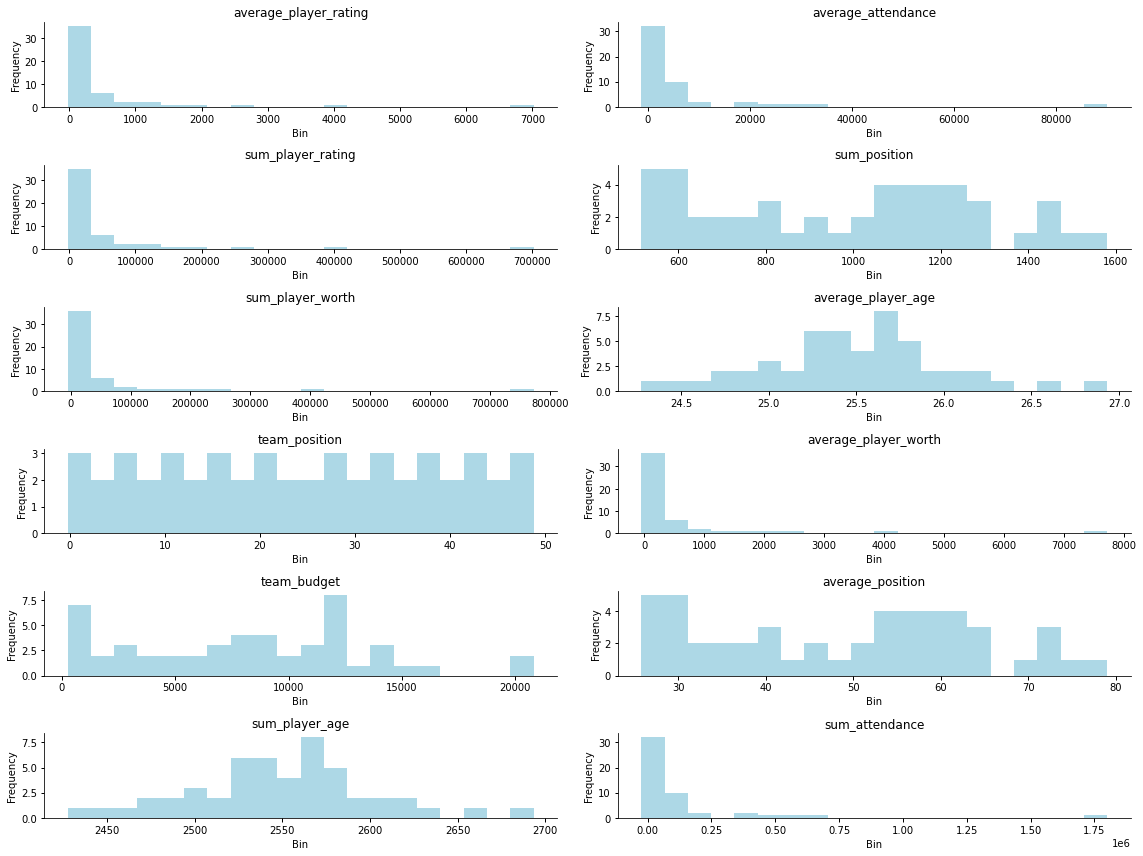

In [115]:
%%local
featurestore.visualize_training_dataset_distributions("team_position_prediction")

You can also override default parameters and set plotting configuration:

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


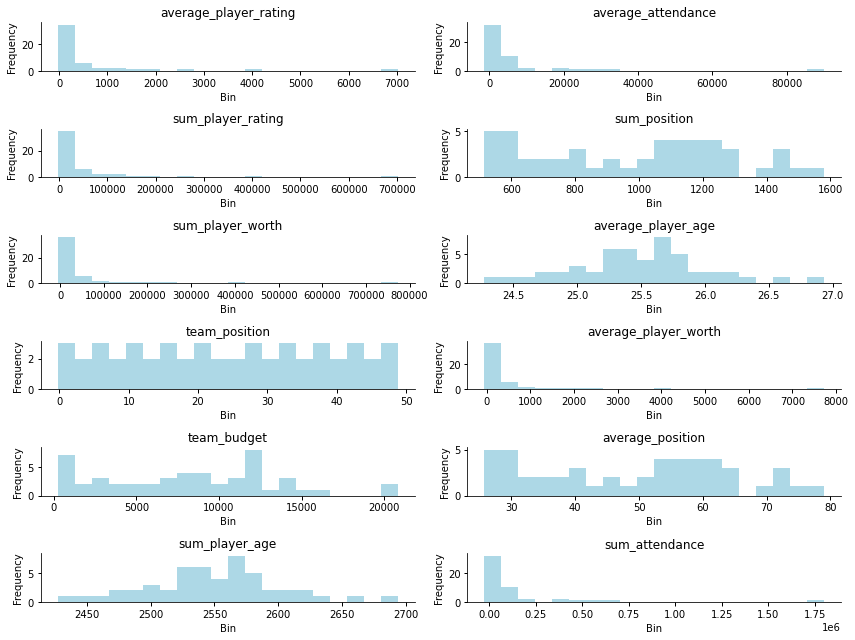

In [116]:
%%local
featurestore.visualize_training_dataset_distributions("team_position_prediction", 
                                                  featurestore=featurestore.project_featurestore(), 
                                                  training_dataset_version=1, 
                                                  figsize=(12, 9),
                                                  color='lightblue', 
                                                  log=False, 
                                                  align="center", 
                                                  plot=True)

You can also compute the figure in the spark kernel (don't have to use `%%local` then) and save it to HDFS for later viewing.

In [117]:
from hops import hdfs
fig = featurestore.visualize_training_dataset_distributions("team_position_prediction", plot=False)
fig.savefig("team_position_prediction_distributions.png")
hdfs.copy_to_hdfs("team_position_prediction_distributions.png", "Resources/", overwrite=True)

Started copying local path team_position_prediction_distributions.png to hdfs path hdfs://rpc.namenode.service.consul:8020/Projects/demo_featurestore_admin000/Resources//team_position_prediction_distributions.png

Finished copying

#### Feature Correlations

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


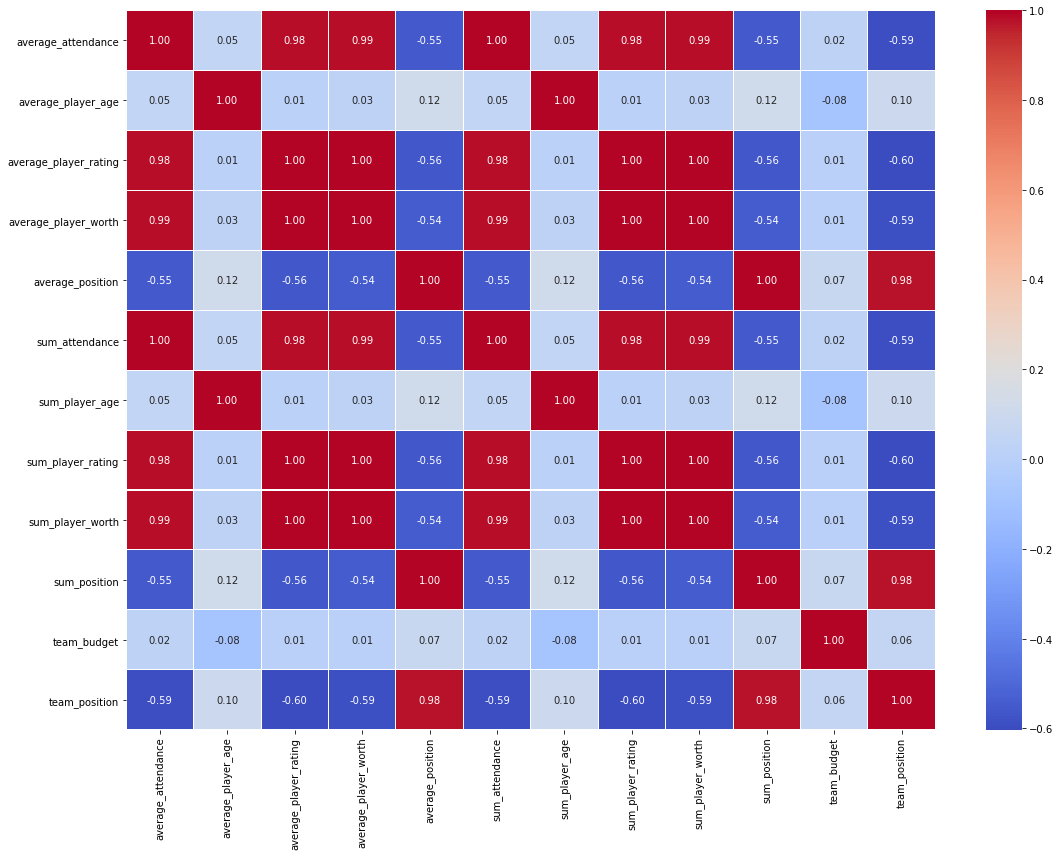

In [118]:
%%local
featurestore.visualize_training_dataset_correlations("team_position_prediction")

You can also override default parameters and set plotting configuration:

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


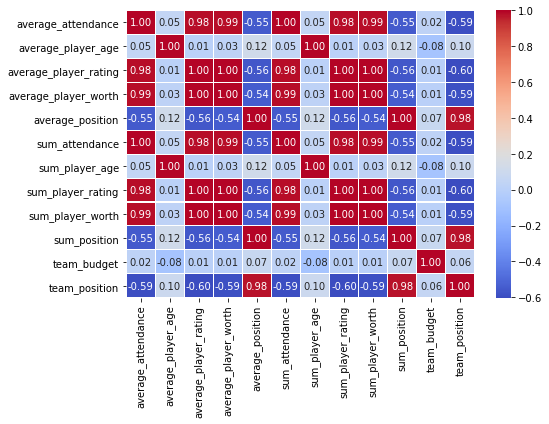

In [119]:
%%local
featurestore.visualize_training_dataset_correlations("team_position_prediction", 
                                                 featurestore=None, 
                                                 training_dataset_version=1, 
                                                 figsize=(8,6),
                                                 cmap="coolwarm", 
                                                 annot=True, 
                                                 fmt=".2f", 
                                                 linewidths=.05, 
                                                 plot=True)

You can also compute the figure in the spark kernel (don't have to use `%%local` then) and save it to HDFS for later viewing.

In [120]:
from hops import hdfs
fig = featurestore.visualize_training_dataset_correlations("team_position_prediction", plot=False)
fig.savefig("team_position_prediction_correlations.png")
hdfs.copy_to_hdfs("team_position_prediction_correlations.png", "Resources/", overwrite=True)

Started copying local path team_position_prediction_correlations.png to hdfs path hdfs://rpc.namenode.service.consul:8020/Projects/demo_featurestore_admin000/Resources//team_position_prediction_correlations.png

Finished copying

#### Feature Clusters

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


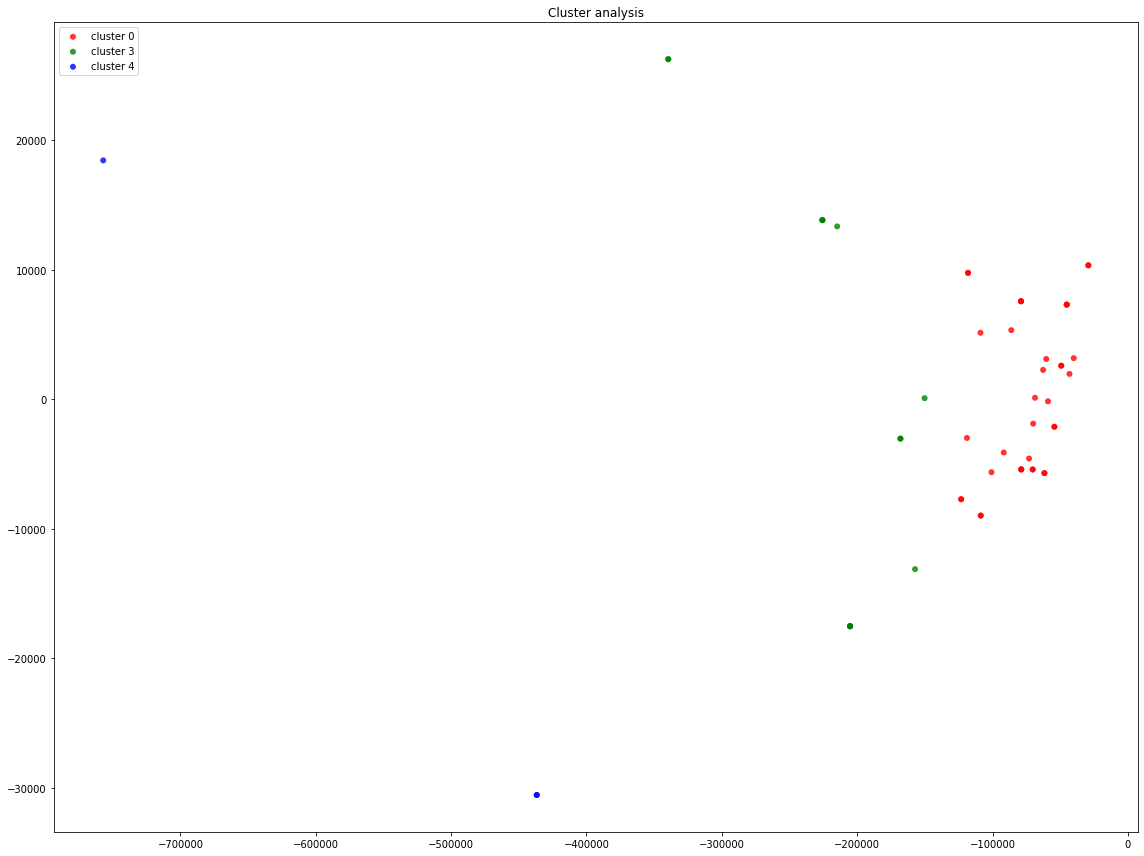

In [121]:
%%local
featurestore.visualize_training_dataset_clusters("team_position_prediction")

You can also override default parameters and set plotting configuration:

Remember to add %%matplotlib inline when doing visualizations in Jupyter notebooks


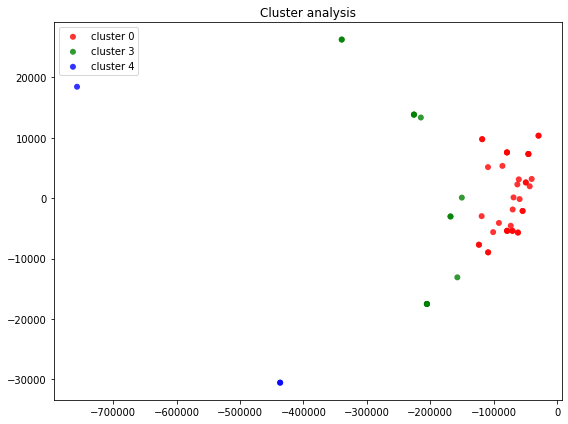

In [122]:
%%local
featurestore.visualize_training_dataset_clusters("team_position_prediction", 
                                featurestore=None, 
                                training_dataset_version=1, 
                                figsize=(8,6),
                                plot=True)

You can also compute the figure in the spark kernel (don't have to use `%%local` then) and save it to HDFS for later viewing.

In [123]:
from hops import hdfs
fig = featurestore.visualize_training_dataset_clusters("team_position_prediction", plot=False)
fig.savefig("team_position_prediction_clusters.png")
hdfs.copy_to_hdfs("team_position_prediction_clusters.png", "Resources/", overwrite=True)

Started copying local path team_position_prediction_clusters.png to hdfs path hdfs://rpc.namenode.service.consul:8020/Projects/demo_featurestore_admin000/Resources//team_position_prediction_clusters.png

Finished copying

#### Descriptive Stats

In [124]:
%%local
desc_stats_df = featurestore.visualize_training_dataset_descriptive_stats("team_position_prediction")
desc_stats_df.head()

Output()

Since descriptive stats is just a pandas table and not a matplotlib figure it does not need a DISPLAY to work, so you can run it from the spark driver or executor as well:

In [125]:
desc_stats_df = featurestore.visualize_training_dataset_descriptive_stats("team_position_prediction")
desc_stats_df.head()

   metric  team_budget  ...  sum_player_rating  average_attendance
0  stddev    5238.9430  ...         118708.750          14232.3090
1     min     760.8729  ...          15096.327           1038.5237
2    mean    8723.2920  ...          71738.375           8669.3940
3   count      50.0000  ...             50.000             50.0000
4     max   21319.5330  ...         719186.300          92301.0860

[5 rows x 13 columns]

### Read Training Dataset

#### Read Training Dataset into a Spark Dataframe

Typically training datasets are served into deep learning frameworks such as pytorch or tensorflow. However, training datasets can also be read into spark dataframes using the api method `get_training_dataset()`

In [126]:
featurestore.get_training_dataset("team_position_prediction_csv").show(5)

+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|team_budget|average_position|sum_player_rating|average_attendance|average_player_worth|sum_player_worth|sum_position|sum_attendance|average_player_rating|team_position|sum_player_age|average_player_age|
+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|  10290.323|            55.0|        32760.031|         4964.6475|            315.4794|       31547.941|      1100.0|     99292.945|             327.6003|           23|        2663.0|             26.63|
|  20347.281|            61.6|        20515.598|         2420.8076|           194.33916|       19433.916|      1232.0|     48416.152|            205.15598|           39|        2618.0|

By default the library will read the training dataset from the project's feature store, use version 1 and return the data in a spark dataframe. This can be overriden:

In [127]:
featurestore.get_training_dataset("team_position_prediction_csv",
                                  featurestore=featurestore.project_featurestore(),
                                  training_dataset_version=1,
                                  dataframe_type="pandas"
                                 ).head()

  team_budget average_position  ... sum_player_age average_player_age
0   10290.323             55.0  ...         2663.0              26.63
1   20347.281             61.6  ...         2618.0              26.18
2   16758.066            55.15  ...         2565.0              25.65
3   3966.3591             57.1  ...         2550.0               25.5
4   4888.2324            32.25  ...         2566.0              25.66

[5 rows x 12 columns]

In [128]:
featurestore.get_training_dataset("team_position_prediction_petastorm",
                                  dataframe_type="spark").show(5)

+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|team_budget|average_position|sum_player_rating|average_attendance|average_player_worth|sum_player_worth|sum_position|sum_attendance|average_player_rating|team_position|sum_player_age|average_player_age|
+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|  16758.066|           55.15|        32269.797|          3271.934|           307.87268|       30787.268|      1103.0|      65438.68|            322.69797|           26|        2565.0|             25.65|
|  3966.3591|            57.1|        29779.197|         4074.8047|           298.78235|       29878.234|      1142.0|      81496.09|            297.79196|           27|        2550.0|

## Get Featurestore Metadata
To explore the contents of the featurestore we recommend using the featurestore page in the Hopsworks UI but you can also get the metadata programmatically from the REST API

### Update Metadata Cache

In [129]:
featurestore.get_featurestore_metadata(update_cache=True)

### List all Feature Stores Accessible In the Project

In [130]:
featurestore.get_project_featurestores()

['demo_featurestore_admin000_featurestore']

### List all Feature Groups in a Feature Store

In [131]:
featurestore.get_featuregroups()

['attendances_features_1', 'games_features_1', 'games_features_double_partitioned_1', 'games_features_hudi_tour_1', 'games_features_on_demand_1', 'games_features_on_demand_tour_1', 'games_features_partitioned_1', 'hive_fs_sync_example_1', 'numpy_test_example_1', 'pandas_test_example_1', 'players_features_1', 'players_features_on_demand_1', 'python_test_example_1', 'season_scores_features_1', 'teams_features_1', 'teams_features_spanish_1', 'teams_features_spanish_2', 'teams_features_spanish_3']

By default `get_featuregroups()` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [132]:
featurestore.get_featuregroups(featurestore=featurestore.project_featurestore())

['attendances_features_1', 'games_features_1', 'games_features_double_partitioned_1', 'games_features_hudi_tour_1', 'games_features_on_demand_1', 'games_features_on_demand_tour_1', 'games_features_partitioned_1', 'hive_fs_sync_example_1', 'numpy_test_example_1', 'pandas_test_example_1', 'players_features_1', 'players_features_on_demand_1', 'python_test_example_1', 'season_scores_features_1', 'teams_features_1', 'teams_features_spanish_1', 'teams_features_spanish_2', 'teams_features_spanish_3']

### List all Features in a Feature Store

In [133]:
featurestore.get_features_list()

['average_attendance', 'sum_attendance', 'team_id', 'away_team_id', 'home_team_id', 'score', 'away_team_id', 'home_team_id', 'score', 'away_team_id', 'home_team_id', '_hoodie_commit_seqno', '_hoodie_commit_time', '_hoodie_file_name', '_hoodie_partition_path', '_hoodie_record_key', 'score', 'away_team_id', 'home_team_id', 'score', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto', 'col_0', 'col_1', 'col_2', 'average_attendance_test', 'average_player_age_test', 'team_budget_test', 'average_player_age', 'average_player_rating', 'average_player_worth', 'sum_player_age', 'sum_player_rating', 'sum_player_worth', 'team_id', 'col_0', 'col_1', 'col_2', 'average_position', 'sum_position', 'team_id', 'team_budget', 'team_id', 'team_position', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto']

By default get_features_list() will use the project's feature store, but this can also be specified with the optional argument featurestore

In [134]:
featurestore.get_features_list(featurestore=featurestore.project_featurestore())

['average_attendance', 'sum_attendance', 'team_id', 'away_team_id', 'home_team_id', 'score', 'away_team_id', 'home_team_id', 'score', 'away_team_id', 'home_team_id', '_hoodie_commit_seqno', '_hoodie_commit_time', '_hoodie_file_name', '_hoodie_partition_path', '_hoodie_record_key', 'score', 'away_team_id', 'home_team_id', 'score', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto', 'col_0', 'col_1', 'col_2', 'average_attendance_test', 'average_player_age_test', 'team_budget_test', 'average_player_age', 'average_player_rating', 'average_player_worth', 'sum_player_age', 'sum_player_rating', 'sum_player_worth', 'team_id', 'col_0', 'col_1', 'col_2', 'average_position', 'sum_position', 'team_id', 'team_budget', 'team_id', 'team_position', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto']

### List all Training Datasets in a Feature Store

In [135]:
featurestore.get_training_datasets()

['team_position_prediction_1', 'team_position_prediction_2', 'team_position_prediction_avro_1', 'team_position_prediction_csv_1', 'team_position_prediction_hdf5_1', 'team_position_prediction_npy_1', 'team_position_prediction_orc_1', 'team_position_prediction_parquet_1', 'team_position_prediction_petastorm_1', 'team_position_prediction_tsv_1', 'tour_training_dataset_test_1']

By default `get_training_datasets()` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [136]:
featurestore.get_training_datasets(featurestore=featurestore.project_featurestore())

['team_position_prediction_1', 'team_position_prediction_2', 'team_position_prediction_avro_1', 'team_position_prediction_csv_1', 'team_position_prediction_hdf5_1', 'team_position_prediction_npy_1', 'team_position_prediction_orc_1', 'team_position_prediction_parquet_1', 'team_position_prediction_petastorm_1', 'team_position_prediction_tsv_1', 'tour_training_dataset_test_1']

### List all Storage Connectors in a Feature Store

In [137]:
featurestore.get_storage_connectors()

[('demo_featurestore_admin000_featurestore', 'JDBC'), ('demo_featurestore_admin000', 'JDBC'), ('demo_featurestore_admin000_meb1_onlinefeaturestore', 'JDBC'), ('demo_featurestore_admin000_Training_Datasets', 'HOPSFS')]

By default `get_storage_connectors()` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [138]:
featurestore.get_storage_connectors(featurestore=featurestore.project_featurestore())

[('demo_featurestore_admin000_featurestore', 'JDBC'), ('demo_featurestore_admin000', 'JDBC'), ('demo_featurestore_admin000_meb1_onlinefeaturestore', 'JDBC'), ('demo_featurestore_admin000_Training_Datasets', 'HOPSFS')]

### Get All Metadata (Features, Feature groups, Training Datasets) for a Feature Store

In [139]:
featurestore.get_featurestore_metadata()

By default `get_featurestore_metadata` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [140]:
featurestore.get_featurestore_metadata(featurestore=featurestore.project_featurestore())

## Tagging featuregroups and training datasets - Only works in Enterprise edition

The feature store enables users to attach tags to a featuregroup or training dataset in order to make them discoverable across projects. 
This is useful in an organization so that data engineers can discover new featuregroups to work with and share them with other data engineers. Furthermore, making training datasets more easily discoverable for data scientists to increase productivity.

### Define tags as admin
A user with admin rights defines a set of organization wide tags that may be attached to featuregroups and training datasets.
In the example below two tags have been defined, "Country" and "Sport".

### Step 1: Navigate to the admin UI

![Feature Store Model](./images/to_admin.png "To admin UI")

### Step 2: Navigate to tag creation UI

![Feature Store Model](./images/admin_fs_tags.png "To admin tags UI")

### Step 3: Create "Country" and "Sport" tags

![Feature Store Model](./images/create_tags.png "Create tags")

In [4]:
tags = featurestore.get_tags()
assert "Country" in tags, "Country not defined in tags, please add it by following the steps above"
assert "Sport" in tags, "Sport not defined in tags, please add it by following the steps above"
tags

['Country', 'Sport']

### Attach tag to featuregroup

In [5]:
featurestore.set_featuregroup_tag("teams_features", "Country", value="Sweden")
featurestore.set_featuregroup_tag("teams_features", "Sport", value="Football")

### Get all tags attached to a featuregroup

In [6]:
featurestore.get_featuregroup_tags("teams_features")

{'Sport': 'Football', 'Country': 'Sweden'}

## From Raw Data to Features to Training Dataset to Model

Once a training dataset have been materialized, we can use it to train a model. The featurestore API makes the integration with libraries such as Tensorflow simple. In this section we will train an example model using the training dataset `team_position_prediction` that we created earlier. We will use the column **"team_position"** as the target to predict.

### Get TFRecords Schema from a Spark Dataframe

This utility method can be used when parsing training datasets in the tfrecords format. Note that this method will try to infer the tensorflow example schema from the schema of the spark dataframe. If you want full control of the tf-record schema you should define it manually.

In [144]:
featurestore.get_dataframe_tf_record_schema(features_df)

{'team_budget': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'team_position': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 'sum_player_age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_age': FixedLenFeature(shape=[], dtype=tf.float32, defa

### Get TFRecords Schema from a Training Dataset

When a training dataset is saved in the tfrecords format, the tfrecord schema is stored together with the training dataset in a file called `tf_record_schema.txt`. This schema can be retrieved when the tfrecords need to be parsed. 

In [145]:
featurestore.get_training_dataset_tf_record_schema("team_position_prediction")

{'team_budget': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'team_position': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 'sum_player_age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_age': FixedLenFeature(shape=[], dtype=tf.float32, defa

By default `get_training_dataset_tf_record_schema` will use the project's feature store and version 1 of the feature grup, this can be overriden if necessary:

In [146]:
featurestore.get_training_dataset_tf_record_schema(
    "team_position_prediction", 
    training_dataset_version=1,
    featurestore = featurestore.project_featurestore()
)

{'team_budget': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'team_position': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 'sum_player_age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_age': FixedLenFeature(shape=[], dtype=tf.float32, defa

### Imports

In this example we will use Tensorflow and Keras. However, the feature store is in theory agnostic to which framework or method you use for training the model, it works with PyTorch, spark-mllib etc.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import json
from hops import hdfs
from hops import experiment
from tensorflow.python.keras.callbacks import TensorBoard
from hops import tensorboard

### Constants and HyperParameters

In [148]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10000
INPUT_SHAPE = 11

### Parse TFRecords into A TF-Dataset

The dataset is stored in `.tfrecords` format, which essentially means it is stored in protobuf format. Moreover, to be able to read and write datasets in the petabyte-scale, the feature store uses distrbuted write/read to HopsFS with Spark, so the dataset is spread out in a large number of files prefixed with `part-r` (if you are unfamiliar with Spark partitions you can read up on Spark [here](https://spark.apache.org/docs/2.1.0/programming-guide.html)). 

Despite that our dataset is stored in a binary format and stored disributed in HopsFSs the amount of code to read the data into a tensorflow dataset is very little, thanks to 

- `featurestore.et_training_dataset_path`: gets the path in HopsFS where the tfrecords files are stored 
- `featurestore.get_training_dataset_tf_record_schema`: gets the tf-record schema to parse the binary data
- `tf.gfile.Glob`: Gets a list of file names from a file-pattern

In [149]:
def create_tf_dataset():
    dataset_dir = featurestore.get_training_dataset_path("team_position_prediction")
    input_files = tf.gfile.Glob(dataset_dir + "/part-r-*")
    dataset = tf.data.TFRecordDataset(input_files)
    tf_record_schema = featurestore.get_training_dataset_tf_record_schema("team_position_prediction")
    feature_names = ["team_budget", "average_attendance", "average_player_age", "sum_attendance", 
         "average_player_rating", "average_player_worth", "sum_player_age", "sum_player_rating", "sum_player_worth", 
         "sum_position", "average_position"
        ]
    label_name = "team_position"

    def decode(example_proto):
        example = tf.parse_single_example(example_proto, tf_record_schema)
        x = []
        for feature_name in feature_names:
            x.append(example[feature_name])
        y = [tf.cast(example[label_name], tf.float32)]
        return x,y

    dataset = dataset.map(decode).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat(NUM_EPOCHS)
    return dataset

### Define The Model using Keras and Tensorflow 

We will use a three-layer neural network for regression on our dataset. In this tutorial we work with so little data that using a larger model does not make sense.

In [150]:
def create_model(num_neurons = 64, learning_rate = 0.001):
    model = tf.keras.Sequential([
        layers.Dense(num_neurons, activation='relu', 
                     input_shape = (INPUT_SHAPE,),
                    batch_size=BATCH_SIZE),
        layers.Dense(num_neurons, activation='relu'),
        layers.Dense(1)])
    return model

### Define Train Function

We define the train code in a separate function so that it can be distributed in the cluster across different executors

In [151]:
def train_fn(num_neurons_per_layer, learning_rate):
    dataset = create_tf_dataset()
    model = create_model()
    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate), loss='mse', metrics=['accuracy'])
    tb_callback = TensorBoard(log_dir=tensorboard.logdir(), histogram_freq=0,
                             write_graph=True, write_images=True)
    callbacks = [tb_callback]
    callbacks.append(keras.callbacks.ModelCheckpoint(tensorboard.logdir() + '/checkpoint-{epoch}.h5',
                                                    monitor='acc', verbose=0, save_best_only=True))
    history = model.fit(dataset, epochs=NUM_EPOCHS, steps_per_epoch = 5, callbacks=callbacks)
    #Return experiment metric (used to direct the search when using hyperparameter search)
    return history.history["acc"][-1]

### Hyperparameter Search 

We will create a reproducible experiment to search for the best hyperparameters for our model using the hops `experiment` module and evolutionary search. 

When the experiment is running you can view the progress in the SparkUI, from there you can also find the tensorboards for the executors.

**Note**: To be able to run this cell you should have started the Jupyter Notebooks Server on Hopsworks with the "Experiment" configuration.

In [ ]:
NUM_EPOCHS = 5
search_dict = {"num_neurons_per_layer" : [64,128], "learning_rate": [0.001, 0.01]}
log_dir, best_params = experiment.differential_evolution(
    train_fn, 
    search_dict, 
    name='team_position_prediction_hyperparam_search', 
    description='Evolutionary search through the search space of hyperparameters with parallel executors to find the best parameters',
    local_logdir=True, 
    population=4,
    generations = 1
)

### Train with the Best Hyperparameters

Now we can train for longer amount of epochs when we have found the best hyperparameters

In [ ]:
best_params

In [ ]:
args_d = {}
args_d["num_neurons_per_layer"] = [int(best_params["num_neurons_per_layer"])]
args_d["learning_rate"] = [float(best_params["learning_rate"])]

In [ ]:
NUM_EPOCHS = 40
experiment_result_path = experiment.launch(
    train_fn, 
    args_dict = args_d,
    name='team_position_prediction_hyperparam_search',
    description="experiment to train model for team position prediction",
    local_logdir=True
)

In [ ]:
experiment_result_path